In [31]:
import numpy as np
from skimage import io
import cv2 as cv
from google.colab.patches import cv2_imshow
import sys

class Node:

  # initialise le noeud avec une liste de coordonnée de pixel
  def __init__(self, pixels):
    self.pixels = pixels
    self.L = self
    self.R = self
    self.L_is_lock = True
    self.R_is_lock = True
    self.size = 0 if pixels is None else len(pixels)

  def __repr__(self):
    return "I'm a leaf" if self.pixels != None else "I'm an intersection : " + str(self.pixels_list())

  def __str__(self):
    return "I'm a leaf" if self.pixels != None else "I'm an intersection"

  # Ajoute 2 enfants à un noeud
  def add_node(self, L, R):
    self.L = L
    self.R = R
    self.L_is_lock = False
    self.R_is_lock = False
    self.size = L.size + R.size

  # Retourne tous les pixels accessible des sous branches à partir du noeud
  def pixels_list(self):
    pile = [self]
    pixels = []

    while pile:
      node = pile.pop()
      if(node.pixels != None):
        pixels += node.pixels
      if(not node.L_is_lock):
        pile.append(node.L)
      if(not node.R_is_lock):
        pile.append(node.R)
    return pixels

  # Permet de bloqué l'accés à des sous branche directe du noeud
  def lock_child(self, lock_L=False, lock_R=False):
    if(self.pixels == None):
      self.L_is_lock = lock_L
      self.R_is_lock = lock_R

  # Permet de débloqué toutes les branches
  def unlock_all(self):
    pile = [self]
    pixels = []

    while pile:
      node = pile.pop()
      if(node.pixels != None):
        node.L_is_lock = True
        node.R_is_lock = True
      else:
        node.L_is_lock = False
        node.R_is_lock = False

      if(not node.L_is_lock):
        pile.append(node.L)
      if(not node.R_is_lock):
        pile.append(node.R)

  # Permet de retourner une image en fonction des pixels accessible depuis le noeud
  def get_image(self, image):
    mask = np.zeros_like(image)
    pixels = self.pixels_list()
    for x,y in pixels:
      mask[x,y] = [250,250,250]
    return cv.bitwise_and(image, mask)

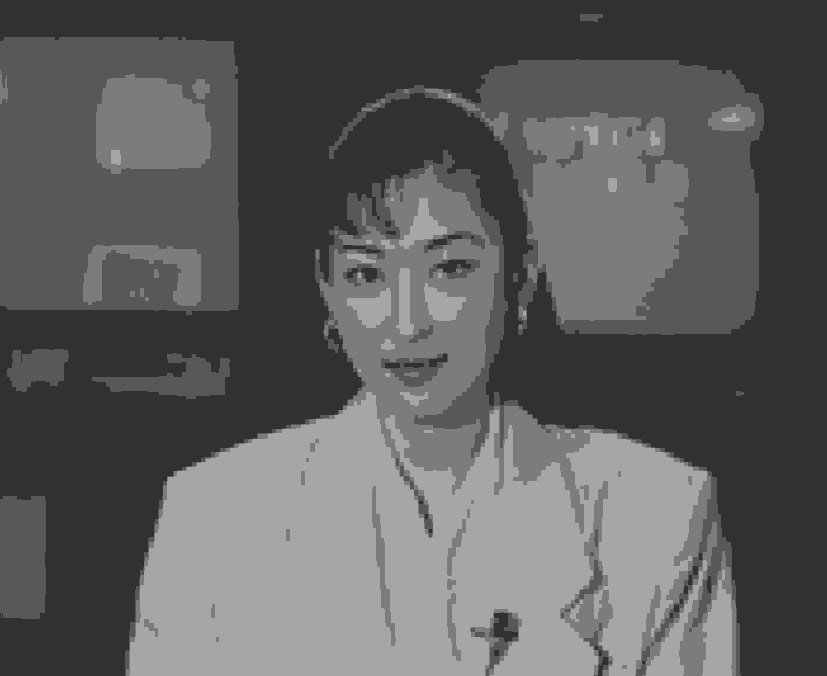

Nombre de régions : 350
Edges calculation ...
Edges calculate.


In [32]:
# Fonction de segmentation d'une image couleur en zone plate en utilisant k-means
def partitionner_image_zone_plate_opencv(image, nombre_de_couleur):
    # Convertir l'image en un tableau NumPy
    image_array = image.reshape((-1, 3))

    # Convertir le type de données en float32 pour k-means
    image_array = np.float32(image_array)

    # Appliquer l'algorithme k-means pour la segmentation
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv.kmeans(image_array, nombre_de_couleur, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    # Convertir les centres en entiers
    centers = np.uint8(centers)

    # Remapper les pixels d'origine en fonction des labels
    segmented_image_array = centers[labels.flatten()]

    # Remettre le tableau à sa forme originale
    segmented_image_array = segmented_image_array.reshape(image.shape)

    return segmented_image_array

# Retourne la liste de pixel composant la region contenant le pixel en position (x,y) dans l'image
def propagation_germe(x, y, segmented, image, couleur_initiale, nouvelle_couleur):
  # Simulation de récursion pour palier à la limite de récursivité
  pile = [(x, y)]
  pixels = []
  while pile:
    x, y = pile.pop()
    if (0 <= x < len(image) and 0 <= y < len(image[0]) and (segmented[x,y]==0) and np.array_equal(image[x, y], couleur_initiale)):
      # Mettre à jour la couleur du pixel (pour indiquer qu'il a déjà été visité)
      segmented[x, y] = nouvelle_couleur
      pixels.append((x,y))

      # Propagation récursive aux pixels voisins
      pile.extend([(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)])
  return pixels


# Construction du RAG
def RAG(image):
  segmented = np.zeros((image.shape[0], image.shape[1]), int)
  nb_regions = 0
  nodes = []
  edges = []
  # Création des noeud représentant chaque région
  for x in range(len(image)):
    for y in range(len(image[0])):
      #si il a un voisin de même couleur
      if (segmented[x,y]== 0):
        nb_regions += 1
        sys.stdout.write(chr(13) + "Nombre de régions : " + str(nb_regions))
        nodes.append(Node(propagation_germe(x, y, segmented, image, image[x,y],nb_regions)))

  # Création des arêtes des régions voisines
  print()
  print("Edges calculation ...")
  for x in range(len(segmented)):
    for y in range(len(segmented[0])):
      if(x < len(segmented)-1 and segmented[x+1,y] != segmented[x,y] and not [segmented[x,y]-1, segmented[x+1,y]-1] in edges and not [segmented[x+1,y]-1, segmented[x,y]-1] in edges):
        edges.append([segmented[x,y]-1, segmented[x+1,y]-1])
      if(y < len(segmented[0])-1 and segmented[x,y+1] != segmented[x,y] and not [segmented[x,y]-1, segmented[x,y+1]-1] in edges and not [segmented[x,y+1]-1, segmented[x,y]-1] in edges):
        edges.append([segmented[x,y]-1 , segmented[x,y+1]-1])
  print("Edges calculate.")

  return nodes, edges


image = cv.imread('image.png')

image_partition = partitionner_image_zone_plate_opencv(image, 4)
cv2_imshow(image_partition)
nodes, edges = RAG(image_partition)

Tree generation
Add node : 349

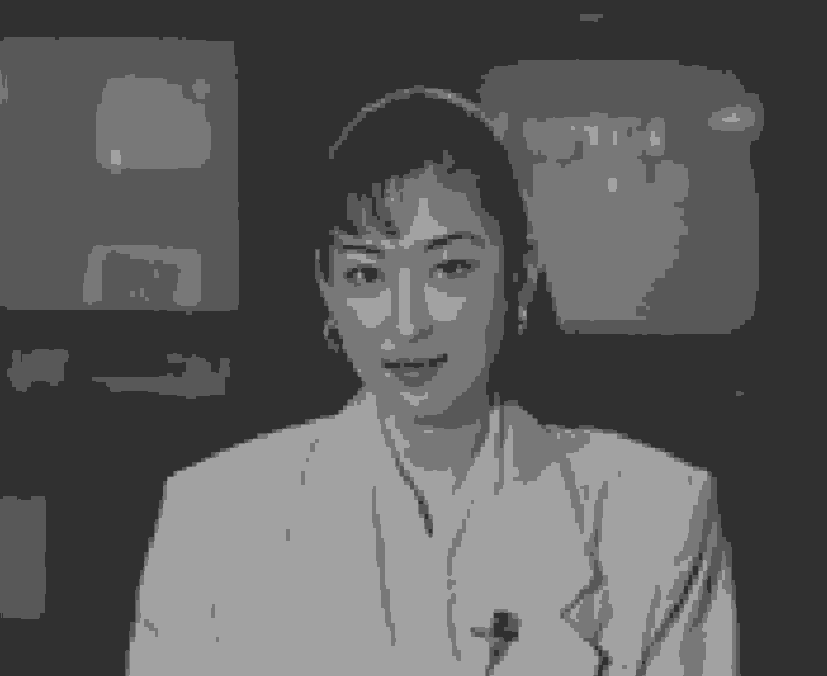

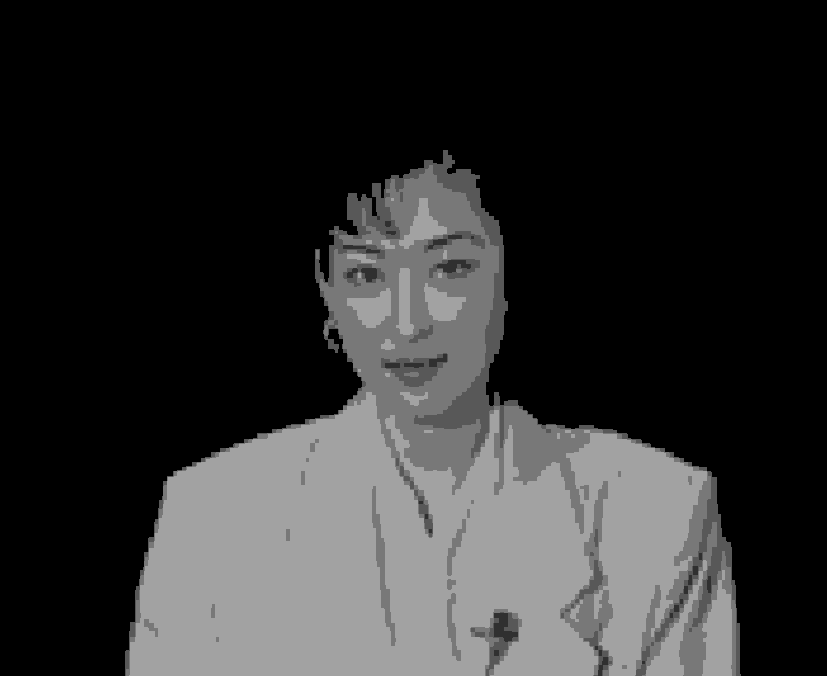

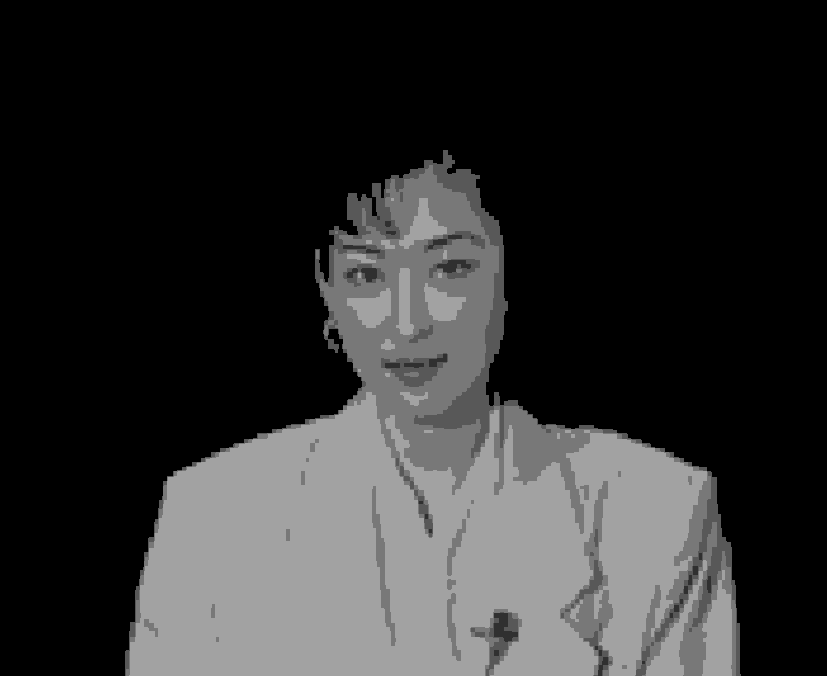

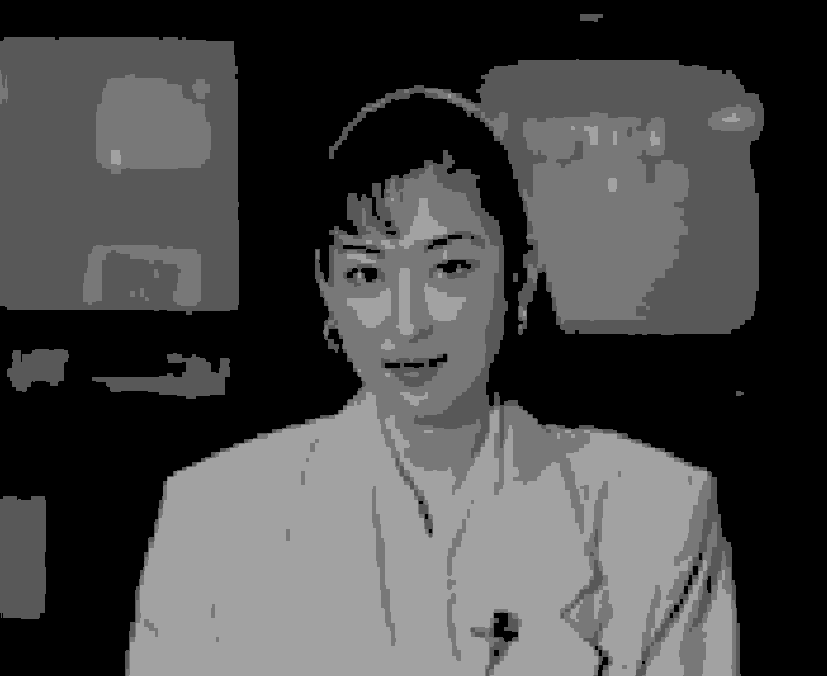

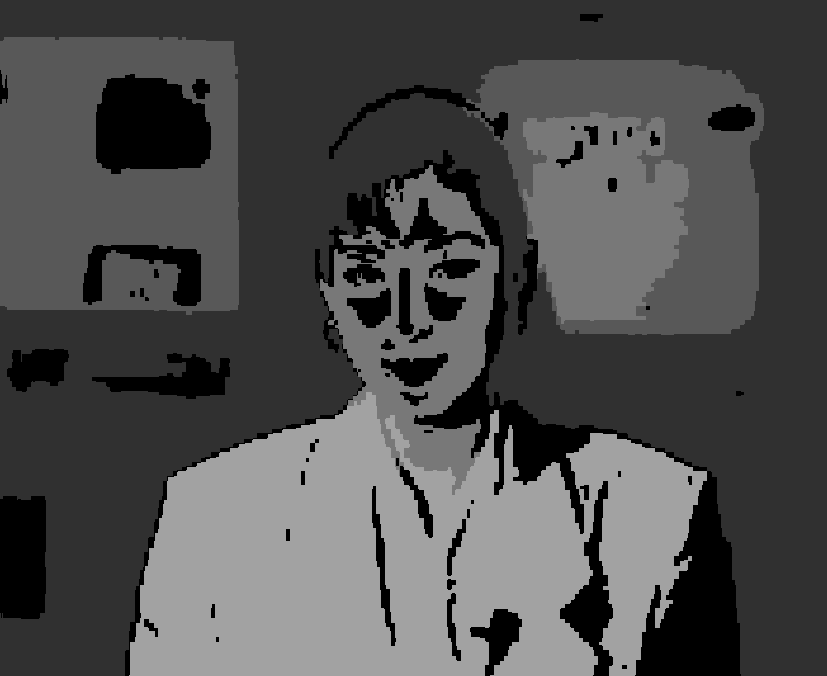

In [33]:
# RAG

MAX = image.shape[0]*image.shape[1]

# Le critère selection de l'arête.
# Plus la valeur de retour est élevé, plus l'arête sera prioritaire
def critere(node1, node2):
  # Critère en fonction de la taille de la region final si fusion des 2
  val1 = node1.size
  val2 = node2.size
  return MAX - (val1 + val2)

# Update the edge in function of a criteria function
# On ne trie pas vraiment la liste, mais on selectionne une arête
# en fonction d'un critère. Cette arête on la place en début de liste
def edges_update(edges, nodes):
  pos = []
  index = 0
  max = 0
  for i in range(len(edges)):
    e = edges[i]
    val = critere(nodes[e[0]],nodes[e[1]])
    if val > max:
      max = val
      pos = e
      index = i
  e = edges[0]
  edges[0] = pos
  edges[index] = e
  return edges

# Permet de créer un arbre en fonction du RAG
def create_tree(edges, nodes):
  print("Tree generation")
  nb_node_added = 1
  while(len(edges)>0):
    edges = edges_update(edges, nodes)
    sys.stdout.write(chr(13) + "Add node : " + str(nb_node_added))
    n = Node(None)
    l_index = edges[0][0]
    r_index = edges[0][1]
    L = nodes[l_index]
    R = nodes[r_index]
    n.add_node(L, R)
    edges.pop(0)
    nodes.append(n)
    index = len(nodes)-1
    nb_node_added += 1

    i = 0
    while i < len(edges):
      modif = False
      e = edges[i]
      edge = [e[0], e[1]]
      if(e[0]==l_index or e[0]==r_index):
        edge[0]=index
        modif = True
      if(e[1]==l_index or e[1]==r_index):
        edge[1]=index
        modif = True
      if edge not in edges:
        tmp = edge[0]
        edge[0] = edge[1]
        edge[1] = tmp
        if edge not in edges:
          edges[i] = [edge[0],edge[1]]
        else:
          edges.remove(e)
          i-=1
      elif modif:
          edges.remove(e)
          i-=1
      i += 1
  return nodes[-1]

tree = create_tree(edges, nodes)
cv2_imshow(tree.get_image(image_partition))

# On affiche que le contenu de la branche de droite
cv2_imshow(tree.R.get_image(image_partition))

# Même affichage que ci-dessus car on bloque la branche de gauche
tree.lock_child(lock_L=True)
cv2_imshow(tree.get_image(image_partition))

# On débloque toutes les branches
tree.unlock_all()

# Effet de bord sur tree
# Permet de filtrer l'image en fonction d'une valeur de gris
# La fonction va bloqué des branches
def filtre1(tree, image, gray_scale):
  node = tree
  pile = [node]
  while pile:
    node = pile.pop()
    L_lock = False
    R_lock = False
    if(node.pixels is None):
      if(node.L.pixels is None):
        pile.append(node.L)
      else:
        pos = node.L.pixels[0]
        L_lock = image[pos[0],pos[1]][0]<gray_scale
      if(node.R.pixels is None):
        pile.append(node.R)
      else:
        pos = node.R.pixels[0]
        R_lock = image[pos[0],pos[1]][0]<gray_scale
      node.lock_child(lock_L=L_lock, lock_R=R_lock)
  return tree

# Effet de bord sur tree
# La fonction bloque des branches si
# la taille d'une région est inférieur à min
def filtre2(tree, min):
  node = tree
  pile = [node]
  while pile:
    node = pile.pop()
    if(node.pixels is None):
      L_lock = False
      R_lock = False
      if(node.L.size < min):
        L_lock = True
      else:
        pile.append(node.L)
      if(node.R.size < min):
        R_lock = True
      else:
        pile.append(node.R)
      node.lock_child(lock_L=L_lock, lock_R=R_lock)
  return tree

filtre1(tree, image_partition, 64)
cv2_imshow(tree.get_image(image_partition))
# Unlock_all permet de retirer le filtre
tree.unlock_all()

filtre2(tree,10000)
cv2_imshow(tree.get_image(image_partition))
# Unlock_all permet de retirer le filtre
tree.unlock_all()